**Importing Libraries**

In [ ]:
import keras
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from time import time
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image, ImageFile

**Dataset**

Dataset of 20580 RGB images of Dogs

**Preprocessing**

Normalization

In [ ]:
path = r'/Users/abhi/Colour2/doge/'
train_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
path = r'/Users/abhi/Colour2/doge/'
train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=512, class_mode=None)

Found 20580 images belonging to 120 classes.


Converting RGB to Lab

In [ ]:
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128)
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

(512, 224, 224, 1)
(512, 224, 224, 2)


**Model**

In [ ]:
vggmodel = keras.applications.vgg16.VGG16()
newmodel = Sequential() 
num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(512, 7, 7, 512)


AutoEncoder

In [ ]:
#Encoder
encoder_input = Input(shape=(7, 7, 512,))

#Decoder
decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_input)
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)

**Training**

In [ ]:
from keras import optimizers
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
history = model.fit(vggfeatures, Y, verbose=1, epochs=1000, batch_size=128)


Epoch 799/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8373
Epoch 800/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8364
Epoch 801/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8360
Epoch 802/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8368
Epoch 803/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8354
Epoch 804/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8335
Epoch 805/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8397
Epoch 806/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0018 - accuracy: 0.8380
Epoch 807/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8372
Epoch 808/1000
4/4 [==============================] - 6s 1s/step - loss: 0.0019 - accuracy: 0.8390
Epoch 809

**Performance Evaluation**

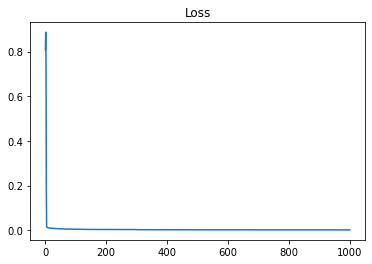

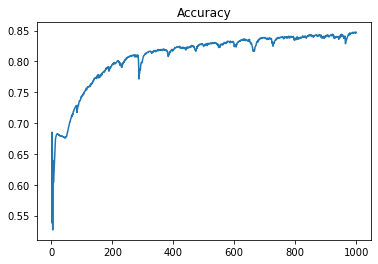

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(1001)
epochs = epochs[1:]
data = []
for key in history.history.keys() :
    data.append(history.history[key])
plt.title("Loss")
plt.plot(epochs, data[0])
plt.show() 
plt.title("Accuracy")
plt.plot(epochs, data[1])
plt.show()

**Results**

In [ ]:
testpath = r'/Users/abhi/Colour2/test/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    #print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    imsave(r'/Users/abhi/Colour2/result/'+str(idx+1)+".jpg", lab2rgb(cur))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0